<a href="https://colab.research.google.com/github/jacr2006/handwritten-digits-discrimination/blob/main/snn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Siamese Neural Network

## Processing data

In [8]:
import tensorflow.keras as keras
import tensorflow as tf
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import random

from sklearn.cluster import KMeans

from keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D
from keras import backend as K

import math

import cv2
from google.colab.patches import cv2_imshow

In [9]:
num_classes = 10

# 
def create_pairs(x, digit_indices):
  pairs = []
  labels = []
   
  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
   
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)
 

Preprocessing images

In [10]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Binarization to 8 bit with range (0 or 255) 
for i in range(x_train.shape[0]):
  x_train[i] = cv2.adaptiveThreshold(x_train[i], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 0)
for i in range(x_test.shape[0]):
  x_test[i] = cv2.adaptiveThreshold(x_test[i], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 0)
x_train = x_train.astype('uint8') 
x_test = x_test.astype('uint8') 

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (1, 28, 28)
print(x_train.shape)

input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)

(60000, 28, 28, 1)


Dataset of pairs creation.

In [11]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)
 
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)
 

In [12]:
tr_pairs.shape

(108400, 2, 28, 28, 1)

## Training

In [13]:
num_features = 32
epochs = 20

# 
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.dtypes.cast(y_true, tf.float64)
    y_pred=tf.dtypes.cast(y_pred, tf.float64)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
 
def create_base_net(input_shape):   
  input = Input(shape = input_shape)
  x = Conv2D(64, (2,2), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Dropout(0.3)(x)
  x = Conv2D(64, (2,2), activation = 'relu')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Dropout(0.3)(x)
  x = Flatten()(x)
  x = Dense(num_features)(x)
  model = Model(input, x)
  return model
 
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
 
 
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

# network definition
base_network = create_base_net(input_shape)

In [14]:
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
 
processed_a = base_network(input_a)
processed_b = base_network(input_b)
 
distance = Lambda(euclid_dis, output_shape=eucl_dist_output_shape) ([processed_a, processed_b])
 
model = Model([input_a, input_b], distance)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 32)           90528       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [15]:
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
model.fit( [tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=64,
          epochs=epochs,
          validation_split=0.2 )

Epoch 1/20
1355/1355 [==============================] - 41s 6ms/step - loss: 46.1674 - accuracy: 0.4957 - val_loss: 0.4647 - val_accuracy: 0.5000
Epoch 2/20
1355/1355 [==============================] - 8s 6ms/step - loss: 0.2713 - accuracy: 0.4976 - val_loss: 0.3282 - val_accuracy: 0.5000
Epoch 3/20
1355/1355 [==============================] - 8s 6ms/step - loss: 0.2510 - accuracy: 0.5549 - val_loss: 0.2274 - val_accuracy: 0.6003
Epoch 4/20
1355/1355 [==============================] - 8s 6ms/step - loss: 0.2074 - accuracy: 0.6815 - val_loss: 0.1945 - val_accuracy: 0.6956
Epoch 5/20
1355/1355 [==============================] - 8s 6ms/step - loss: 0.1847 - accuracy: 0.7319 - val_loss: 0.1933 - val_accuracy: 0.6990
Epoch 6/20
1355/1355 [==============================] - 8s 6ms/step - loss: 0.1741 - accuracy: 0.7553 - val_loss: 0.1818 - val_accuracy: 0.7276
Epoch 7/20
1355/1355 [==============================] - 8s 6ms/step - loss: 0.1674 - accuracy: 0.7689 - val_loss: 0.1567 - val_accurac

In [16]:
y_pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_te)
 
print('accuracy on test set: %0.4f' % (te_acc))


accuracy on test set: 0.9460


## Testing

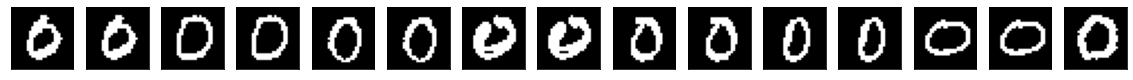

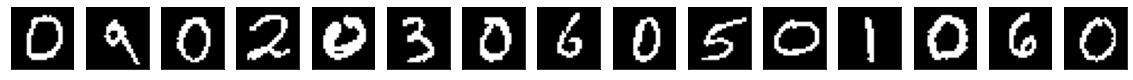

[0.17416531]
[0.729728]
[0.09679835]
[0.7438197]
[0.23180215]
[0.95373136]
[0.428622]
[0.70716465]
[0.2646089]
[0.98546445]
[0.15119155]
[1.069798]
[0.17036411]
[0.7192007]
[0.24329747]


In [17]:
import matplotlib.pyplot as plt
from PIL import Image

number_of_items = 15
 
im = tf.keras.preprocessing.image.array_to_img(
    te_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)
 
plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( te_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
 
plt.figure(figsize=(20, 10))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( te_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
 
for i in range(number_of_items):
  print(y_pred_te[i])



## Inference

Get CNN submodel from SNN model

In [204]:
for l in model.layers:
  print(l.name)

input_15
input_16
model_9
lambda_4


In [206]:
sub_model = model.get_layer('model_9')

In [207]:
for l in sub_model.layers:
  print(l.name)

input_14
conv2d_10
average_pooling2d_10
dropout_10
conv2d_11
average_pooling2d_11
dropout_11
flatten_5
dense_5


In [208]:
sub_model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'input_14')>

In [209]:
sub_model.output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_5')>

Inferences some samples using CNN submodel

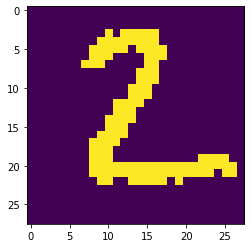

[[ 0.00598245  0.01094826  0.00493547 -0.10339545  0.00582973  0.00991176
  -0.10856445  0.01089851  0.0241727  -0.0022396   0.1407542  -0.00207312
  -0.06910374 -0.00027617 -0.1778948   0.00355988  0.00708698  0.00181477
   0.06703335 -0.00490566  0.21650647  0.02829038  0.15005162 -0.1653221
   0.01982423  0.04229931  0.00686496 -0.01768237  0.00993796  0.00671908
   0.00809961 -0.05170371]]


'\nsample_1 = te_pairs[INDEX_1,0]\nplt.imshow(sample_1.reshape(28, 28))\nplt.show()\nsample_pred_1 = sub_model.predict(sample_1.reshape(1,28, 28,1))\nprint(sample_pred_1)\n'

In [220]:
INDEX_1 = 1

sample_1 = x_test[INDEX_1]
sample_1 = sample_1.reshape(1,28, 28,1)
plt.imshow(sample_1.reshape(28, 28))
plt.show()
sample_pred_1 = sub_model.predict(sample_1)
print(sample_pred_1)


'''
sample_1 = te_pairs[INDEX_1,0]
plt.imshow(sample_1.reshape(28, 28))
plt.show()
sample_pred_1 = sub_model.predict(sample_1.reshape(1,28, 28,1))
print(sample_pred_1)
'''

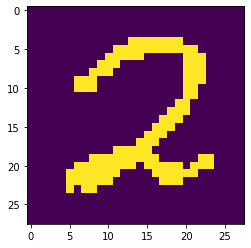

[[-0.08666976  0.00191372  0.01599233 -0.12423776  0.01139277  0.0097519
  -0.12298267  0.00999821  0.05829636  0.00429596  0.12871769 -0.00346765
  -0.02160189  0.04394291 -0.31725308  0.00570099  0.00665898 -0.01916667
   0.07835153 -0.00199468  0.08327616  0.04453442  0.07120608 -0.22974488
   0.01772423 -0.1381833   0.00192028 -0.0170091  -0.17147173  0.00838506
  -0.03015555  0.0840202 ]]


'\nsample_2 = te_pairs[INDEX_2,1]\nplt.imshow(sample_2.reshape(28, 28))\nplt.show()\nsample_pred_2 = sub_model.predict(sample_2.reshape(1,28, 28,1))\nprint(sample_pred_2)\n'

In [221]:
INDEX_2 = 35

sample_2 = x_test[INDEX_2]
sample_2 = sample_2.reshape(1,28, 28,1)
plt.imshow(sample_2.reshape(28, 28))
plt.show()
sample_pred_2 = sub_model.predict(sample_2)
print(sample_pred_2)


'''
sample_2 = te_pairs[INDEX_2,1]
plt.imshow(sample_2.reshape(28, 28))
plt.show()
sample_pred_2 = sub_model.predict(sample_2.reshape(1,28, 28,1))
print(sample_pred_2)
'''

Calculate distance between two features outputs, have to be the same previous result

In [222]:
d = sample_pred_1, sample_pred_2
print( euclid_dis( d ) )

tf.Tensor([[0.38576087]], shape=(1, 1), dtype=float32)


In [232]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [233]:
PATH_DRIVE = '/content/drive/MyDrive/Colab Notebooks/'

In [234]:
modelpath = PATH_DRIVE+'mnist_discriminator_snn_model_v1.h5'
modellitepath = PATH_DRIVE+'mnist_discriminator_snn_model_v1.tflite'

Save model

In [235]:
sub_model.save(modelpath)

Transform model to tflite

In [236]:
import tensorflow as tf

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(sub_model)
sub_model_lite = converter.convert()

# Save the model.
with open(modellitepath, 'wb') as f:
  f.write(sub_model_lite)

INFO:tensorflow:Assets written to: /tmp/tmpguykdvk7/assets


## Others test

K-means of features

In [226]:
features_test = sub_model.predict(x_test)

In [227]:
features_test.shape

(10000, 32)

In [228]:
features_kmean = KMeans(n_clusters=num_classes, random_state=0).fit(features_test)

Centroids of num_classes witk num_features length

In [229]:
features_kmean.cluster_centers_.shape

(10, 32)

Samples of the same class blongs to the same clusters

In [230]:
for s in range(num_classes):
  d = sample_pred_1, features_kmean.cluster_centers_[s]
  print( euclid_dis(d) )

tf.Tensor([[0.6762014]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.57209903]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.63599014]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8565641]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.83355665]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.3120535]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.76235276]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.56706655]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5562663]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8038031]], shape=(1, 1), dtype=float32)


In [231]:
for s in range(num_classes):
  d = sample_pred_2, features_kmean.cluster_centers_[s]
  print( euclid_dis(d) )

tf.Tensor([[0.964572]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.66808426]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.65028566]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.8520703]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.7552812]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.15077285]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.92764723]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.73674953]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5934094]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5778818]], shape=(1, 1), dtype=float32)


Inference from binary

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
PATH_DRIVE = '/content/drive/MyDrive/Colab Notebooks/'

In [55]:
modelpath = PATH_DRIVE+'mnist_discriminator_snn_model_v1.h5'
modellitepath = PATH_DRIVE+'mnist_discriminator_snn_model_v1.tflite'

In [56]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving number_2.bin to number_2 (1).bin
User uploaded file "number_2.bin" with length 784 bytes


In [77]:
import struct

FILE_NAME = "number_2.bin"
with open(FILE_NAME,"rb") as f:
	dataRaw = f.read(-1)
 
raw = [struct.unpack('b', dataRaw[i:i+1]) for i in range( int(len(dataRaw)) ) ]
num=np.array(raw)
num = num.astype('uint8')
num = num.reshape(1,28,28,1)

In [78]:
# load model and run inference
sub_model = keras.models.load_model(modelpath)
res_bin = sub_model.predict(num)# inferenc
res_bin

array([[-0.00980516,  0.01000309,  0.00904152, -0.08552109,  0.00881474,
         0.01404266, -0.13346389,  0.00309362,  0.03533191, -0.00033231,
         0.04282258, -0.00184346,  0.02427614,  0.00961228, -0.24478139,
         0.00455176,  0.00675865, -0.00534478,  0.05066783, -0.00415691,
         0.08168683,  0.03350793,  0.13000649, -0.169953  ,  0.01574269,
        -0.08194277,  0.00484529, -0.01484193, -0.15158956,  0.01004891,
         0.00046152,  0.01306815]], dtype=float32)

Inference from image

In [67]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving number_2.png to number_2 (1).png
User uploaded file "number_2.png" with length 321 bytes


In [79]:
FILE_NAME = "number_2.png"
img=cv2.imread( FILE_NAME )
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
img = img.astype('uint8') 
img = img.reshape(1, 28, 28,1)

In [80]:
# load model and run inference
sub_model = keras.models.load_model(modelpath)
res_img = sub_model.predict(img)# inferenc
res_img

array([[-7.9491436e-03,  1.3514444e-02,  1.1151239e-02, -8.5600048e-02,
         1.1344516e-02,  1.8432535e-02, -1.3084112e-01,  1.5995605e-04,
         4.2154748e-02, -3.8926457e-03,  4.8472509e-02, -4.1052559e-03,
         9.9335518e-03,  9.3949195e-03, -2.5578201e-01,  7.0570353e-03,
         3.3936007e-03, -8.8245217e-03,  4.0110942e-02, -8.2717706e-03,
         8.2400464e-02,  3.7378252e-02,  1.2954043e-01, -1.6902925e-01,
         2.0730089e-02, -9.2678331e-02,  1.7262779e-03, -1.9888330e-02,
        -1.4847653e-01,  7.0845992e-03, -4.8074634e-03,  2.8929070e-02]],
      dtype=float32)

In [81]:
d = res_bin, res_img
print( euclid_dis( d ) )

tf.Tensor([[0.03364818]], shape=(1, 1), dtype=float32)
